```
This problem is a stochastic version of the knapsack problem. We know that much and we are having trouble generating candidate solutions.
```

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import scipy as sp
import math

import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

import seaborn as sns
import warnings

from sklearn.utils.extmath import cartesian
from collections import defaultdict
from itertools import product

warnings.filterwarnings('ignore')

np.random.seed(2017)

%run ../src/santa_helper.py

### Underlying probability distribution for each item

In [2]:
def sample_horse(size=1):
    return np.maximum(0, np.random.normal(5,2,size))

def sample_ball(size=1):
    return np.maximum(0, 1 + np.random.normal(1,0.3,size))

def sample_bike(size=1):
    return np.maximum(0, np.random.normal(20,10,size))

def sample_train(size=1):
    return np.maximum(0, np.random.normal(10,5,size))

def sample_coal(size=1):
    return 47 * np.random.beta(0.5,0.5,size)

def sample_book(size=1):
    return np.random.chisquare(2,size)

def sample_doll(size=1):
    return np.random.gamma(5,1,size)

def sample_block(size=1):
    return np.random.triangular(5,10,20,size)

def sample_gloves(size=1):
    dist1 = 3.0 + np.random.rand(size)
    dist2 = np.random.rand(size)
    toggle = np.random.rand(size) < 0.3
    dist2[toggle] = dist1[toggle]
    return dist2

samplers = {
    "horse": sample_horse,
    "ball": sample_ball,
    "bike": sample_bike,
    "train": sample_train,
    "coal": sample_coal,
    "book": sample_book,
    "doll": sample_doll,
    "blocks": sample_block,
    "gloves": sample_gloves
}

def sample(gift_type, quantity=1, size=1):
    """
    Use the sampling method for a gift type to generate samples
    from the underlying distribution.
    
    Also takes quantity and size as the parameters which represent
    how many iterations should we consider and what should be the sample size for each of
    the iteration.
    """
    return np.sum(samplers[gift_type](quantity * size).reshape(quantity, size), axis=0)

** Now if we want to weight estimation of a bag containing 2 horses and we want to generate 10 samples **

In [3]:
print('Estimation of weight of bag containing two horses: \n{}'.format(sample('horse', 2, 10)))

Estimation of weight of bag containing two horses: 
[  4.82637366   7.80104358   7.53720465  12.97055717   9.63975113
   8.05202214   8.11415732   7.4164609    8.10915182   6.12412129]


In [4]:
# load gift items
gifts = pd.read_csv('../data/gifts.csv'); gifts.head()

,GiftId
0,horse_0
1,horse_1
2,horse_2
3,horse_3
4,horse_4


In [5]:
gift_types_list   = parse_gift_type(gifts)
gift_counts       = gift_types_list.value_counts()
unique_gifts      = gift_counts.index.values

In [6]:
print('Count for every item ', gift_counts.values)
print('Number of items are available: ', np.sum(gift_counts))
print('Unique items available to us are: ', unique_gifts)

Count for every item  [1200 1100 1000 1000 1000 1000  500  200  166]
Number of items are available:  7166
Unique items available to us are:  ['book' 'ball' 'train' 'horse' 'doll' 'blocks' 'bike' 'gloves' 'coal']


** Search Space **

In [7]:
print('Size of the search space ', np.sum(np.log(gift_counts.values)))

Size of the search space  58.3490766638


Search space is around $e^{58}$ which means the space is huge and we would have to be clever enough to only conisder reasonable candidates.

In [7]:
def bag_name(bag):
    return str(list(map(lambda gift: "{}({})".format(gift, bag[gift]), sorted(bag.keys()))))

def create_bag_weight_sampler(bag):
    def bag_weight_sampler(size=1):
        weight = np.array([0.0]*size)
        for gift in sorted(bag.keys()):
            weight += sample(gift, bag[gift], size)
        return weight
    return bag_weight_sampler, bag_name(bag)

bag = { "horse": 1, "ball": 2 } # this defines that bag contains 1 horse and 2 balls
bag_weight_sampler, name = create_bag_weight_sampler(bag)
print("Weight estimations for this bag {}: {}".format(name, bag_weight_sampler(10)))

Weight estimations for this bag ['ball(2)', 'horse(1)']: [ 11.07989868   9.0213798    6.85237687   8.19870475   4.59779781
   9.15103981   6.0782703    7.41647187   9.25937581  10.54216101]


#### Plot weight estimates for each candidate ( bag )

['book(1)', 'horse(2)']: mean=12.018761434887095 | std=3.5102605113772345
['ball(2)', 'horse(1)']: mean=9.012789506289119 | std=2.0126845467460552
['ball(1)']: mean=2.00202528020715 | std=0.3001094540729906
['bike(1)']: mean=20.217204900956204 | std=9.780419611692931
['train(1)']: mean=10.025292525807563 | std=4.895800470297536
['coal(1)']: mean=23.323512994574067 | std=16.629852653604985
['book(1)']: mean=1.9999589731772547 | std=1.9759229938903402
['doll(1)']: mean=4.988727895119982 | std=2.2188089549268466
['blocks(1)']: mean=11.677478388311739 | std=3.132245130041533
['gloves(1)']: mean=1.40651167977616 | std=1.4075395121365537
['bike(1)', 'coal(1)']: mean=43.7637325173457 | std=19.145095363064595
['horse(2)', 'train(1)']: mean=20.116829758726492 | std=5.623154119073732


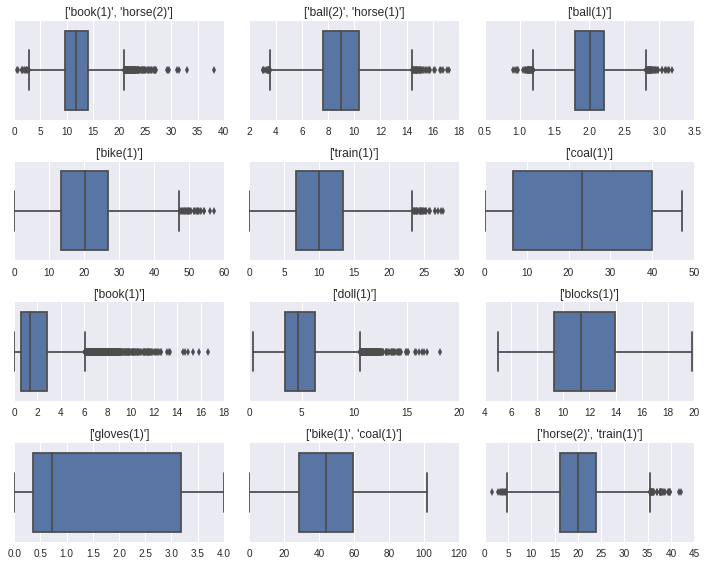

In [9]:
def plot_bag_weight_distributions(bags, size=10000):
    plot_distributions(bags, create_bag_weight_sampler, size=size)

def plot_distributions(bags, sampler_builder, size=10000, fit=None):
    num_plots = len(bags)
    num_cols = int(round(math.sqrt(num_plots)))
    num_rows = (num_plots // num_cols)
    num_rows = num_rows if num_plots % num_cols == 0 else num_rows + 1
    
    f, axes = plt.subplots(num_rows, num_cols, figsize=(10, 8))
    axes = axes.reshape(-1)
    for i in range(num_plots):
        current_bag = bags[i]
        current_bag_sampler, current_bag_name = sampler_builder(current_bag)
        current_sample = current_bag_sampler(size)
        print("{}: mean={} | std={}".format(current_bag_name, np.mean(current_sample), np.std(current_sample)))
        current_axis = axes[i]
#         sns.distplot(current_sample, ax=current_axis, fit=fit, kde=False)
        # plot a boxplot
        sns.boxplot(x=current_sample, ax=current_axis)
        current_axis.set_title(current_bag_name)
        current_axis.set_yticklabels([])
    plt.tight_layout()
    plt.show()
    
single_gift_bags = [
    {"horse": 2, "book": 1},
    {"ball": 2, "horse": 1},
    {"ball": 1},
    {"bike": 1},
    {"train": 1},
    {"coal": 1},
    {"book": 1},
    {"doll": 1},
    {"blocks": 1},
    {"gloves": 1},
    {'bike':1, 'coal':1},
    {'horse':2, 'train': 1}
]

plot_bag_weight_distributions(single_gift_bags)

In [9]:
example_bags = [
    {'bike': 2, 'blocks': 2, 'book': 2, 'doll': 2, 'gloves': 2, 'horse': 2},
#     {"horse": 1, "ball": 2},
#     {"train": 3, "bike": 1},
#     {"coal": 2, "book": 2},
#     {"gloves": 12, "book": 12},
]

In [10]:
def plot_bag_utility_distributions(bags, size=10000):
    plot_distributions(bags, create_bag_utility_sampler, size=size, fit=None)

def create_bag_utility_sampler(bag):
    bag_weight_sampler, bag_name = create_bag_weight_sampler(bag)
    def bag_utility_sampler(size=1):
        samples = bag_weight_sampler(size)
        samples[samples > 50] = 0 # clip all those samples where weight > 50 ( dangerous )
        return samples
    return bag_utility_sampler, bag_name

bag = { "horse": 2, "ball": 19 }
bag_utility_sampler, name = create_bag_utility_sampler(example_bags[0])
print("Sampling utility from bag {}: {}\n".format(name, bag_utility_sampler(3)))
# plot_bag_utility_distributions(example_bags)

Sampling utility from bag ['bike(2)', 'blocks(2)', 'book(2)', 'doll(2)', 'gloves(2)', 'horse(2)']: [ 0.  0.  0.]



In [11]:
np.random.seed(42) # reset seed to make things reproducibe even if you fiddle around in the part above

def get_gift_weight_distributions(gifts, size=10000):
    def get_gift_weight_dsitribution(gift):
        sampler = samplers[gift]
        sample = sampler(size)
        return np.mean(sample), np.std(sample) # return sample mean and sample variance
    
    distributions = np.zeros((len(gifts), 2)) # 2 columns one for mean and variance
    for i, gift in enumerate(gifts):
        distributions[i, :] = get_gift_weight_dsitribution(gift)
    return distributions

gift_types = sorted(samplers.keys())
print("Canonical gift order: {}\n".format(gift_types))
gift_weight_distributions = get_gift_weight_distributions(gift_types)
print(pd.DataFrame(data=gift_weight_distributions, index=gift_types, columns=["mean", "std"]))

Canonical gift order: ['ball', 'bike', 'blocks', 'book', 'coal', 'doll', 'gloves', 'horse', 'train']

             mean        std
ball     1.999359   0.301024
bike    20.229937   9.782352
blocks  11.613023   3.084284
book     2.005699   2.018248
coal    23.510956  16.646331
doll     5.006272   2.244458
gloves   1.414070   1.408373
horse    5.008280   1.972852
train   10.088743   4.904175


In [12]:
def get_mixed_item_bags_max_quantities(upper_limit=None):
    """
    Another shot at looking at possible combinations that we could try, since
    we know that total weight carried by a bag cannot exceed 50 which means
    that there is upper bound on quantity of items we could fit in a bag based on
    the sample mean that we have already estimated.
    
    This is just one strategy to cut the search space we would have to think of much
    clever strategy to cut through the search space.
    
    Notes: 
    1. This strategy returns 526500000 as the total number of different
    candidates which must be considered.
    2. Upper Bounds are calcualted based on the constraints which says that total weight cannot
       exceed 50.
    """
    max_quantities = np.ceil(50 / gift_weight_distributions[:, 0])
    if upper_limit is not None:
        max_quantities[max_quantities > upper_limit] = upper_limit
    return max_quantities

mixed_item_max_quantities = get_mixed_item_bags_max_quantities()
print("maximum quantities:\n{}".format(np.dstack((np.array(gift_types), mixed_item_max_quantities)).squeeze()))
print("number of different bags: {}".format(np.prod(mixed_item_max_quantities)))

maximum quantities:
[['ball' '26.0']
 ['bike' '3.0']
 ['blocks' '5.0']
 ['book' '25.0']
 ['coal' '3.0']
 ['doll' '10.0']
 ['gloves' '36.0']
 ['horse' '10.0']
 ['train' '5.0']]
number of different bags: 526500000.0


In [13]:
mixed_item_max_quantities = get_mixed_item_bags_max_quantities(11)
print("maximum quantities:\n{}".format(np.dstack((np.array(gift_types), mixed_item_max_quantities)).squeeze()))
print("number of different bags: {}".format(np.prod(mixed_item_max_quantities)))

maximum quantities:
[['ball' '11.0']
 ['bike' '3.0']
 ['blocks' '5.0']
 ['book' '11.0']
 ['coal' '3.0']
 ['doll' '10.0']
 ['gloves' '11.0']
 ['horse' '10.0']
 ['train' '5.0']]
number of different bags: 29947500.0


In [14]:
def create_candidate_bags(max_quantities):
    """
    Define the search space
    """
    gift_counts = []
    for max_quantity in max_quantities:
        gift_counts.append(np.arange(max_quantity))
    return cartesian(gift_counts)

In [15]:
mixed_item_candiadte_bags = create_candidate_bags(mixed_item_max_quantities)
print("Created candiadate bags: {}".format(mixed_item_candiadte_bags.shape))

Created candiadate bags: (29947500, 9)


### How to generate good candidate bags ?

Only consider those bags where weight less than 50 and greater than 30.

In [16]:
def get_bag_weight_distributions(candidate_bags, min_mean=30, max_mean=50):
    return np.dot(candidate_bags, gift_weight_distributions)

def filter_by_mean(bags, distributions, min_mean=30, max_mean=50):
    min_mask = mean_of(distributions) > min_mean
    distributions = distributions[min_mask]
    bags = bags[min_mask]
    max_mask = mean_of(distributions) < max_mean
    distributions = distributions[max_mask]
    bags = bags[max_mask]
    return bags, distributions

def mean_of(distributions):
    return distributions[:,0]

mixed_item_bag_weight_distributions = get_bag_weight_distributions(mixed_item_candiadte_bags)
mixed_item_candiadte_bags, mixed_item_bag_weight_distributions = \
    filter_by_mean(mixed_item_candiadte_bags, mixed_item_bag_weight_distributions)
print("Candidate bags left: {}".format(mixed_item_candiadte_bags.shape))

Candidate bags left: (58957, 9)


In [17]:
def get_low_weight_item_candidate_bags():
    bags = []
    distributions = []
    for gift in ["ball", "book", "gloves"]:
        max_quantities = get_low_weight_item_bags_max_quantities_for(gift)
        candiadte_bags = create_candidate_bags(max_quantities)
        bags.append(candiadte_bags)
        cadidate_bag_weight_distributions = get_bag_weight_distributions(candiadte_bags)
        distributions.append(cadidate_bag_weight_distributions)
    return np.vstack(bags), np.vstack(distributions)
        

def get_low_weight_item_bags_max_quantities_for(gift):
    max_quantities = np.ceil(50 / gift_weight_distributions[:, 0])
    gift_index = gift_types.index(gift)
    for i in range(len(max_quantities)):
        if not i == gift_index:
            max_quantities[i] = 5
    print("Gift {}: number of different bags: {}".format(gift, np.prod(max_quantities)))
    return max_quantities

low_weight_item_candidate_bags, low_weight_item_bag_weight_distributions = \
    filter_by_mean(*get_low_weight_item_candidate_bags())
print("Total number of canidate bags: {}".format(low_weight_item_candidate_bags.shape))

Gift ball: number of different bags: 10156250.0
Gift book: number of different bags: 9765625.0
Gift gloves: number of different bags: 14062500.0
Total number of canidate bags: (82817, 9)


In [18]:
def drop_duplicate(candidate_bags, distributions):
    df = pd.DataFrame(data=np.hstack((candidate_bags, distributions)), columns=gift_types + ["mean", "std"])
    df.drop_duplicates(subset=gift_types, inplace=True)
    return df[gift_types].values, df[["mean", "std"]].values

candidate_bags = np.vstack([mixed_item_candiadte_bags, low_weight_item_candidate_bags])
bag_weight_distributions = np.vstack([mixed_item_bag_weight_distributions, low_weight_item_bag_weight_distributions])
print("Combined candiadte bags: {}".format(candidate_bags.shape))
candidate_bags, bag_weight_distributions = drop_duplicate(candidate_bags, bag_weight_distributions)
print("Final candidate bags without duplicates: {}".format(candidate_bags.shape))

Combined candiadte bags: (141774, 9)
Final candidate bags without duplicates: (71071, 9)


In [19]:
def get_bag_utility_distributions(candidate_bags):
    distributions = []
    size = len(candidate_bags)
    for i, candidate_bag in enumerate(candidate_bags):
        if i % 7000 == 0:
            print("{:.4f}\r".format(float(i) / float(size)))
        distributions.append(get_bag_utility_distribution(candidate_bag))
    print("")
    return np.vstack(distributions)

def get_bag_utility_distribution(candidate_bag):
    bag = { gift_types[i]: int(candidate_bag[i]) for i in range(len(gift_types)) if candidate_bag[i] > 0 }
    sampler, name = create_bag_utility_sampler(bag)
    sample = sampler(10000)
    return np.mean(sample), np.var(sample)

bag_utility_distributions = get_bag_utility_distributions(candidate_bags)
print(bag_utility_distributions.shape)

0.0000
0.0985
0.1970
0.2955
0.3940
0.4925
0.5910
0.6895
0.7879
0.8864
0.9849

(71071, 2)


In [20]:
num_gifts_available = {
    "horse": 1000,
    "ball": 1100,
    "bike": 500,
    "train": 1000,
    "book": 1200,
    "doll": 1000,
    "blocks": 1000,
    "gloves": 200,
    "coal": 166
}

In [21]:
def pack_linprog(bags, distributions, min_variance, max_bags=1000):
    # objective: c.T * x -> min
    c = - distributions[:,0] # optimize sum of expected bag utilities
    
    # constraint: A_ub * x <= b_ub
    A_ub = bags.T # don't use more gifts than available
    b_ub = np.array([num_gifts_available[gift] for gift in gift_types])
    
    A_ub = np.vstack([A_ub, np.ones(A_ub.shape[1])]) # pack at most max_bags gifts
    b_ub = np.hstack([b_ub, [max_bags]])
    
    if min_variance is not None:
        A_ub = np.vstack([A_ub, -distributions[:,1]]) # require minimum variance
        b_ub = np.hstack([b_ub, [-min_variance]])
    
    result = sp.optimize.linprog(c, A_ub=A_ub, b_ub=b_ub)
    if result["success"] == False:
        return [], True
    else:
        return result["x"].astype('int64'), False


def pack_bags(bags, distributions, min_variance=None):
    max_bags = 1000
    bag_quantities, infeasible = pack_linprog(bags, distributions, min_variance=min_variance)
    while np.sum(bag_quantities) < 1000:
        max_bags += 1
        bag_quantities, infeasible = pack_linprog(bags, distributions, min_variance=min_variance, max_bags=max_bags)
        if max_bags > 1015:
            print("WARNING: not getting 1000 bags")
            break
        if infeasible:
            continue
    
    if infeasible:
        print("infeasible")
        return [], [], []
    
    chosen_bag_idx = np.where(bag_quantities)[0]
    chosen_bags = bags[chosen_bag_idx]
    chosen_distributions = distributions[chosen_bag_idx]
    chosen_quantities = bag_quantities[chosen_bag_idx]
    
    while np.sum(chosen_quantities) > 1000:
        idx = np.random.randint(len(chosen_quantities))
        chosen_quantities[idx] = max (chosen_quantities[idx]-1, 0)
    
    score_distribution = np.dot(chosen_quantities, chosen_distributions)
    print("{} bags - score distribution: mean = {:.2f} | var = {:.2f}"
          .format(np.sum(chosen_quantities), score_distribution[0], score_distribution[1]))
    
    return chosen_bags, chosen_distributions, chosen_quantities

packed_bags, packed_distributions, packed_quantities \
    = pack_bags(candidate_bags, bag_utility_distributions, min_variance=None)

1000 bags - score distribution: mean = 35573.17 | var = 104987.61


In [22]:
def create_submissions(bags, quantities, num_submissions=60):
    def create_stock(n):
        stock = { gift: list(map(lambda id: "{}_{}".format(gift, id) ,np.arange(num_gifts_available[gift]))) for gift in gift_types }
        return shuffle(stock, n)
    
    def shuffle(stock, seed):
        np.random.seed(seed)
        for gift in stock.keys():
            np.random.shuffle(stock[gift])
        return stock
    
    def generate_submission(n):
        stock = create_stock(n)
        with open("../submissions/submission_{}.csv".format(n), 'w+') as submission_file:
            submission_file.write('Gifts\n')
            for i in range(len(bags)):
                for quantity in range(quantities[i]):
                    current_gifts = bags[i]
                    for gift_idx, gift_quantity in enumerate(current_gifts[:len(gift_types)]):
                        gift_name = gift_types[gift_idx]
                        for j in range(int(gift_quantity)):
                            submission_file.write("{} ".format(stock[gift_name].pop()))
                    submission_file.write("\n")
    
    for n in range(num_submissions):
        generate_submission(n)
        
create_submissions(packed_bags, packed_quantities)

** Stochastic Optimization **

Different components of the stochastic optimization:
* Optimization/ Search
    * Stochastic Simulator
        * Sample Generator
        * Simulation Output
    * Search and compare

In [46]:
class Optimization:
    """
    Optimization means exploring the search space in an efficient way so as to find the candidate
    that would maximize the objective function.
    
    In stochastic optimization we need to have a method that when a given a candidate would
    be able to perform simulations. Simulations would require samples which would be generated
    by a sample generator and each sample needs to be evaluated for performance metric and that
    will be the work of simulation output.
    
    For efficiently exploring different search space we would need to way to generate different
    candidates for that we would try out different strategies.
    
    """
    class Stochastic_Simulator:
        def __init__(self, candidate, gift_types, n_bags, sample_size):
            self.candidate   = candidate
            self.gift_types  = gift_types
            self.n_bags      = n_bags
            self.sample_size = sample_size
            
        def simulation_output(self):
            """
            Given a candidate return back the utility of the candidate.
            
            Candidate: 2D numpy array that would hold the configuration of each of the
                       individual bag. e.g. 2D array of size (2, 9) represent configuration
                       of two bags.
                       
                       Each configuration contains the count of gift type that is included in
                       the bag.
            """
            
            def get_estimate_weight_bag(bag):
                """
                Parameter
                ----------

                bag         : List of count of different gift types.
                
                Return
                ------

                Estimated weight of the bag.
                """

                candidate_bag = dict(list(zip(self.gift_types, bag)))
                bag_utility_sampler, name = self.sample_generator(candidate_bag)
                return bag_utility_sampler(self.sample_size)

            def get_estimate_weight_bags(candidate):
                estimators = np.zeros(shape=(len(candidate), 2)) # for mean and std
                
                for i in range(len(candidate)):
                    bag_estimator    = get_estimate_weight_bag(candidate[i, :])
                    estimators[i, 0] = estimators[i, 0] + bag_estimator.mean()
                    estimators[i, 1] = estimators[i, 1] + bag_estimator.std()
                    
                return estimators
            
            estimated_weight_bags = get_estimate_weight_bags(self.candidate)
            return estimated_weight_bags
        
        def create_bag_weight_sampler(self, bag):
            def bag_name(bag):
                return str(list(map(lambda gift: "{}({})".format(gift, bag[gift]), sorted(bag.keys()))))

            def bag_weight_sampler(size=1):
                weight = np.array([0.0]*size)
                for gift in sorted(bag.keys()):
                    weight += sample(gift, bag[gift], size)
                return weight
            
            return bag_weight_sampler, bag_name(bag)

        
        def sample_generator(self, bag):
            """
            Generate samples of weight for each of the gift item present in the bag.
            """
            
            bag_weight_sampler, bag_name = self.create_bag_weight_sampler(bag)
            def bag_utility_sampler(size=1):
                samples = bag_weight_sampler(size)
                samples[samples > 50] = 0 # clip all those samples where weight > 50 ( dangerous )
                return samples
            
            return bag_utility_sampler, bag_name
    
    class Candidate:
        """
        Responsibility of this class is to generate candidate/ design.
        
        Constraint: Number of items in each bag must be greater than or equal to 3.
        
        """
        def __init__(self):
            pass
    
    def __init__(self, objective_function, higher_is_better=True):
        self.objective_function = objective_function
        self.higher_is_better   = higher_is_better
        
    

In [133]:
def constraint_1(candidate, gift_counts):
    """
    Sum of the all columns must be less than the total count of the gift type.
    """
    return np.all(np.sum(candidate, axis=0) <= gift_counts)
    
def constraint_2(candidate):
    """
    Sum of all the rows must be greater than or equal to 3.
    """
    return np.all(np.sum(candidate, axis=1) >= 3)

def candidate_creation(max_quantities, gift_counts):
    candidates = []
    
    def create_potential_candidate():
        return np.array([np.random.randint(low=0, high=2) \
                         for i in range(10 * 9)])\
                       .reshape(10, 9)
    
    while len(candidates) < 1: # moment we encounter a candidate break out of the loop
        potentital_candidate = create_potential_candidate()
        
        if constraint_1(potentital_candidate, gift_counts) and constraint_2(potentital_candidate):
            candidates.append(potentital_candidate)
    
    return candidates

In [134]:
candidate = candidate_creation(mixed_item_max_quantities, gift_counts.values)
candidate

[array([[0, 1, 0, 1, 0, 1, 1, 1, 1],
        [1, 0, 1, 0, 1, 0, 1, 1, 1],
        [0, 0, 0, 0, 0, 0, 1, 1, 1],
        [0, 1, 0, 0, 0, 1, 1, 1, 1],
        [1, 0, 0, 1, 1, 1, 1, 1, 0],
        [0, 1, 0, 1, 1, 0, 1, 0, 0],
        [0, 0, 0, 1, 1, 0, 1, 0, 1],
        [1, 1, 0, 0, 0, 1, 0, 0, 0],
        [0, 1, 0, 1, 0, 1, 0, 0, 1],
        [1, 1, 1, 0, 1, 1, 1, 0, 0]])]

In [135]:
optimization    = Optimization(None)
stoch_simulator = optimization.Stochastic_Simulator(candidate[0], gift_types, 10, 10000)
np.sum(stoch_simulator.simulation_output(), axis=0)

array([ 211.41633978,  153.80849727])

### Linear Programming

In [ ]:
def estimate_weights(gift_types, quantity=1, sample_size=1):
    return np.array([np.mean(sample(gift_type, quantity, sample_size)) for gift_type in gift_types])

In [378]:
def get_availability_vector(is_available):
    return is_available * -1

def calculate_availability(gift_counts):
    return (gift_counts[gift_counts > 0] > 0)

def fill_bag(weights, gift_counts, max_weight, min_items): 
    is_available = calculate_availability(gift_counts)
    c = -weights[gift_counts > 0]
    A = [weights[gift_counts > 0], get_availability_vector(is_available)]
    b = [max_weight, -min_items]
    
    res = sp.optimize.linprog(c, A, b)
    return res['x'].astype('int')

def add_to_bag(gift_types, gift_counts, allocation):
    allocation_index = 0
    bag = []
    
    for i in range(len(gift_counts)):
        if gift_counts[i] > 0:
            if allocation[allocation_index] > 0:
                amount_to_assign = min(gift_counts[i], allocation[allocation_index])
                bag.append('{}_{}'\
                           .format(gift_types[i], str(amount_to_assign)))
            allocation_index += 1
    
    return bag

def fill_bags(n_bags, gift_counts, gift_types):
    bags = []
    weights = estimate_weights(gift_types, 1, 1e6)
    
    for i in range(n_bags):
        allocation = fill_bag(weights, gift_counts, 50, 4)
        bags.append(add_to_bag(gift_types, gift_counts, allocation))
        gift_counts[gift_counts > 0] = gift_counts[gift_counts > 0] - allocation
        
    return bags

In [380]:
solution = fill_bags(1000, gift_counts.copy().values, unique_gifts)

In [381]:
def init_gift_type_count(gift_counts, seed=2017):
    np.random.seed(seed)
    gift_counter = {}
    
    for idx in gift_counts.index:
        gift_counter[idx] = np.arange(0, gift_counts.ix[idx])
        np.random.shuffle(gift_counter[idx])
    
    return gift_counter

def numeric_to_text(solution, gift_counts):
    solution_with_names = []
    gift_counter = init_gift_type_count(gift_counts)
    gift_type_count = defaultdict(int)
    
    for row in solution:
        text = []
        for sol in row:
            gift_type, quantity = sol.split('_')
            
            for i in range(int(quantity)):
                gift_index = gift_counter[gift_type][gift_type_count[gift_type]]
                text.append('{}_{}'.format(gift_type, gift_index))
                gift_type_count[gift_type] += 1
        
        solution_with_names.append(text)
    
    return solution_with_names

In [382]:
solution_with_names = numeric_to_text(solution, gift_counts)

* Linear Progamming Solution                :    __23564.47097__ 
* Linear Programming Solution after shuffle :    __23550.14599__
* Linear Programming Solution using mean weight estimation: __27933.34845__

In [384]:
prepare_solution('linear_prog_shuffled_mean_weights', solution_with_names)